## Ex 2

In [ ]:
import site
import sys

# Make sure user path to venv site-packages is in system path
user_site = site.getusersitepackages()
if user_site not in sys.path:
    sys.path.append(user_site)

!pip install --user "numpy<2" matplotlib torch botorch gpytorch

In [2]:
from matplotlib import pyplot as plt
import torch

import numpy as np

from botorch.models import SingleTaskGP
from botorch.acquisition import UpperConfidenceBound
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms import Normalize, Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf

### Helpers

In [3]:
def build_gp_model(
    train_X: torch.tensor,
    train_Y: torch.tensor,
    param_bounds: torch.tensor,
) -> SingleTaskGP:
    """Build GP model with integrated scalers for in- and output."""
    outcome_transform = Standardize(m=1)
    outcome_transform.train()

    n_params = param_bounds.size(1)
    gp_model = SingleTaskGP(
        train_X=train_X,
        train_Y=train_Y,
        input_transform=Normalize(d=n_params, bounds=param_bounds),
        outcome_transform=outcome_transform,
    )
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_mll(mll)
    return gp_model


def get_predictions(gp_model: SingleTaskGP, X: torch.tensor) -> torch.tensor:
    """Get predictions from GP model (mean and stddev)."""
    with torch.no_grad():
        posterior = gp_model.posterior(X)
        pred_mean = posterior.mean
        pred_stddev = posterior.variance.sqrt()
    return pred_mean, pred_stddev


def get_next_candidate(
    gp_model: SingleTaskGP,
    param_bounds: torch.tensor,
    beta: float = 2.0,
) -> torch.tensor:
    """Optimize acquisition function to get next candidate."""
    acqf = UpperConfidenceBound(gp_model, beta=beta)
    candidate, acq_value = optimize_acqf(
        acq_function=acqf,
        bounds=param_bounds,
        q=1,
        num_restarts=10,
        raw_samples=512,
    )
    return candidate


def plot_evaluation(
    param_bounds: torch.tensor,
    n_eval_x: int,
    gp_model: SingleTaskGP,
    train_X: torch.tensor,
    train_Y: torch.tensor,
):
    # Evaluate ground truth
    x_eval = torch.linspace(param_bounds[0, 0], param_bounds[1, 0], n_eval_x).unsqueeze(-1)
    y_true = objective_fun(x_eval)

    # Predictions
    pred_mean, pred_stddev = get_predictions(gp_model, x_eval)

    # Plot ground truth and predictions
    plt.figure(figsize=(7, 5))
    plt.plot(x_eval, y_true, c="grey", ls="--", label="Ground truth")
    plt.plot(x_eval, pred_mean, c="tab:blue", label="Predicted mean")
    plt.fill_between(
        x_eval.squeeze(),
        pred_mean.squeeze() - pred_stddev.squeeze(),
        pred_mean.squeeze() + pred_stddev.squeeze(),
        color="tab:blue",
        alpha=0.2,
        label="Predicted stddev",
    )
    plt.scatter(train_X, train_Y, marker="x", s=60, c="tab:red", label="Training data", zorder=10)
    plt.scatter(train_X[-1, :], train_Y[-1, :], marker='d', s=60, c="blue", label="Candidate", zorder=20)
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()

### Objective

In [4]:
def objective_fun(X: torch.tensor) -> torch.tensor:
    return torch.sin(X[..., 0])

### Initial data collection and BO

it=0: candidate=tensor([[0.]], dtype=torch.float64)


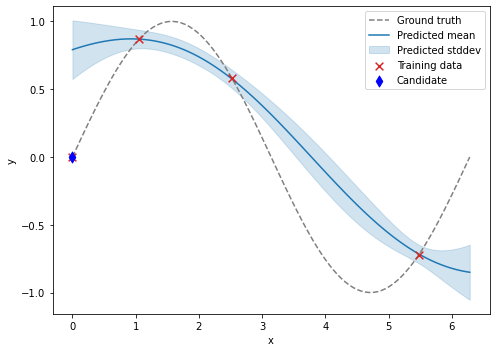

it=1: candidate=tensor([[1.6391]], dtype=torch.float64)


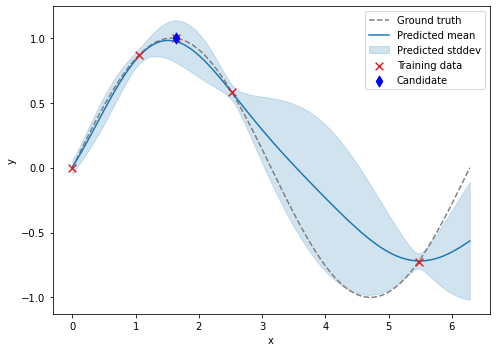

it=2: candidate=tensor([[1.5865]], dtype=torch.float64)


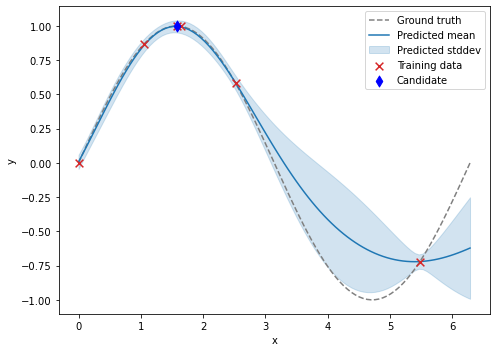

it=3: candidate=tensor([[1.5755]], dtype=torch.float64)


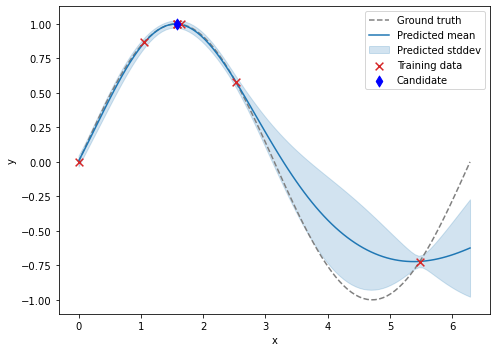

it=4: candidate=tensor([[1.5668]], dtype=torch.float64)


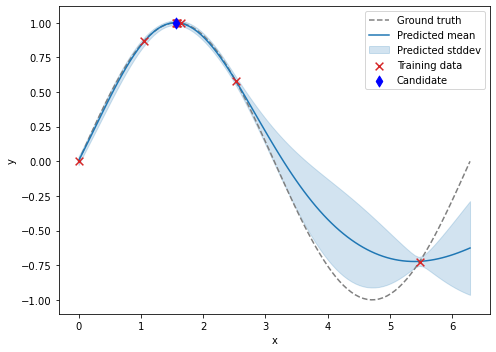

In [6]:
N_INITIAL = 3
N_POINTS_BO = 5
PARAM_BOUNDS = torch.tensor([[0.0], [2.*np.pi]], dtype=torch.float64)


# I) Collect initial random points (could be also just 1 point to start)
train_X = PARAM_BOUNDS[0] + (PARAM_BOUNDS[1] - PARAM_BOUNDS[0]) * torch.rand(
    N_INITIAL,
    PARAM_BOUNDS.size(1),
    dtype=torch.float64,
)
train_Y = objective_fun(train_X).unsqueeze(-1)

# II) BO loop
for it in range(N_POINTS_BO):
    # a) Initialize and fit model with latest data
    gp_model = build_gp_model(train_X, train_Y, PARAM_BOUNDS)

    # b) Optimize acquisition function to get next candidate
    candidate = get_next_candidate(gp_model, PARAM_BOUNDS, beta=1.0)
    print(f"{it=}: {candidate=}")

    # c) Evaluate objective function (e.g. on machine, in simulation,
    # etc.) and update data sets
    new_y = objective_fun(candidate).unsqueeze(-1)
    train_X = torch.cat([train_X, candidate], dim=0)
    train_Y = torch.cat([train_Y, new_y], dim=0)

    # d) (optional) Plot evaluation
    plot_evaluation(PARAM_BOUNDS, 100, gp_model, train_X, train_Y)
